# Employess Analysis
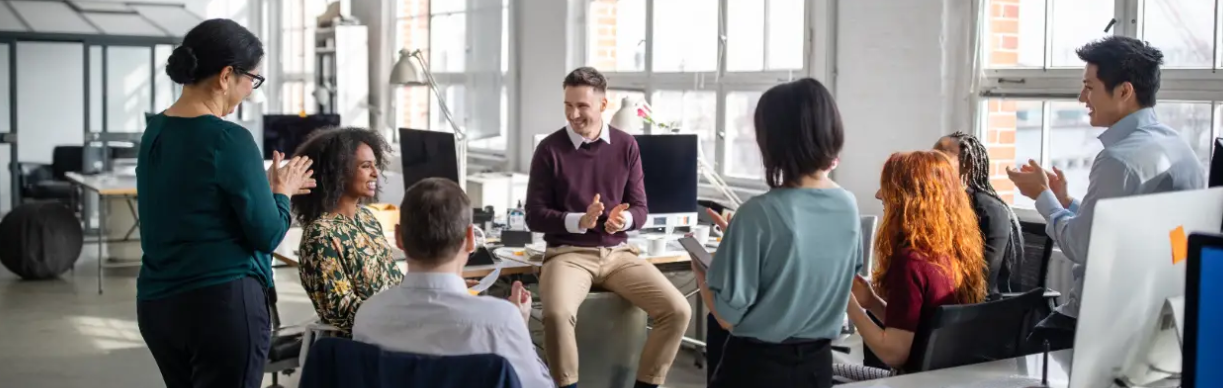
## Introduction

In this project we will be exploring data related to employees. We will be using the [EmployeeData.csv](https://drive.google.com/file/d/1sLvCEUOmbL341MApio5RC05nHpgGrq06/view?usp=sharing) dataset which contains information about employees such as: Education, Joinning year, City, Payment tier, current experience, etc.

## Objectives
- Data Cleaning
- Exploratory Data Analysis
- Data Visualization
- Train a Model to predict leaving the company
- Conclusion


# Development the objectives of this project

In [103]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## 1. Data preprocessing

In [26]:
def find_cols_with_nan(df: pd.DataFrame) -> list:
    """
        This function returns a list of columns that have N/A values
    """
    return df.columns[df.isna().any()].tolist()

In [49]:
#Read the dataset
employees_df = pd.read_csv('employeesData.csv')
# Len of the dataset before cleaning
len_data_before = len(employees_df)

In [50]:
# Verify if the data has N/A values and replace them using the mean
if employees_df.isnull().values.any():
    
    cols_na = find_cols_with_nan(employees_df)
    print('There are N/A values in the dataset in the following columns:')
    print(cols_na)
    for col in cols_na:
        # Delete N/A values in ExperienceInCurrentDomain and JoiningYear
        if col == 'ExperienceInCurrentDomain' or col == 'JoiningYear':
            print(f'Deleting N/A values in {col}')
            employees_df = employees_df.dropna(subset=[col])
        # Replace N/A values in Age with the mean
        elif col == 'Age':
            mean = employees_df[col].mean()
            print(f'Replacing N/A values in {col} with the mean: {mean}')
            employees_df[col].fillna(mean, inplace=True)
        # Replace N/A values in Gender with the mode
        else:
            mode = employees_df[col].mode()[0]
            print(f'Replacing N/A values in {col} with the mode: {mode}')
            employees_df[col].fillna(mode, inplace=True)
        
    print('The dataset has been cleaned successfully')

There are N/A values in the dataset in the following columns:
['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain']
Deleting N/A values in JoiningYear
Replacing N/A values in PaymentTier with the mode: 3.0
Replacing N/A values in Age with the mean: 29.69128540305011
Deleting N/A values in ExperienceInCurrentDomain
The dataset has been cleaned successfully


In [51]:
# Change the values in the LeaveOrNot column from 0 and 1 to 'Yes' and 'No'
employees_df['LeaveOrNot'] = employees_df['LeaveOrNot'].replace({0: 'Not Leave', 1: 'Leave'})

In [52]:
# Delete row with outliers using IQR in the numerical columns
for column in employees_df.columns:
    # verify if the column is numerical
    if employees_df[column].dtype == 'float64' or employees_df[column].dtype == 'int64':
        Q1 = employees_df[column].quantile(0.25)
        Q3 = employees_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # verify if there are outliers
        if employees_df[column].min() < lower_bound or employees_df[column].max() > upper_bound:
            print(f"Column {column} has outliers which will be deleted")
            # delete outliers
            employees_df = employees_df.query(f"{column} >= {lower_bound} and {column} <= {upper_bound}")
            print("Outliers has been eliminated in the column {}".format(column))
        else:
            print(f"Column {column} does not have outliers")

Column JoiningYear does not have outliers
Column PaymentTier has outliers which will be deleted
Outliers has been eliminated in the column PaymentTier
Column Age has outliers which will be deleted
Outliers has been eliminated in the column Age
Column ExperienceInCurrentDomain does not have outliers


In [56]:
# Verify how many rows have been deleted
len_data_after = len(employees_df)
print(f'{len_data_before - len_data_after} rows have been deleted')

1231 rows have been deleted


In [54]:
# See the result of the cleaning with a sample of 5 rows
employees_df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017.0,Bangalore,3.0,34.0,Male,No,0.0,Not Leave
2,Bachelors,2014.0,New Delhi,3.0,38.0,Female,No,2.0,Not Leave
3,Masters,2016.0,Bangalore,3.0,27.0,Male,No,5.0,Leave
4,Masters,2017.0,Pune,3.0,24.0,Male,Yes,2.0,Leave
6,Bachelors,2015.0,New Delhi,3.0,38.0,Male,No,0.0,Not Leave


## 2. Exploratory Data Analysis

In [70]:
plt.style.use('classic')

### 2.1. Visualize the sex distribution

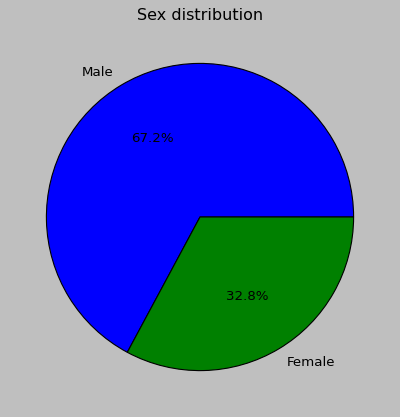

In [71]:
# Plort the sex distribution

plt.pie(employees_df['Gender'].value_counts(), 
        labels=employees_df['Gender'].unique(), # Get the unique values in the column: ['Male', 'Female']
        autopct='%1.1f%%')
plt.title('Sex distribution')
plt.show()

Insight 1: Male employees are more than female employees.

### 2.2. Visualize the education distribution

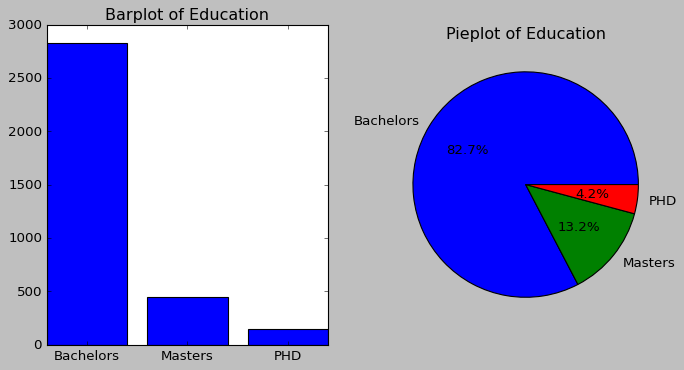

In [81]:
fig, ax = plt.subplots(1, 2,figsize=(10, 5))

ax[0].bar(employees_df['Education'].value_counts().index, employees_df['Education'].value_counts())
ax[0].set_title('Barplot of Education')
ax[1].pie(employees_df['Education'].value_counts(), labels=employees_df['Education'].value_counts().index, autopct='%1.1f%%')
ax[1].set_title('Pieplot of Education')
plt.show()

Insight 2: There are many more Bachelor's degrees than other degrees.

### 2.3. Are young employees more likely to leave the company?

In [91]:
# Dataframe of age of employees who leave
employees_leave_age = employees_df[employees_df['LeaveOrNot'] == 'Leave']['Age']

<Axes: title={'center': 'Age of employees who leave'}, xlabel='Age', ylabel='Count'>

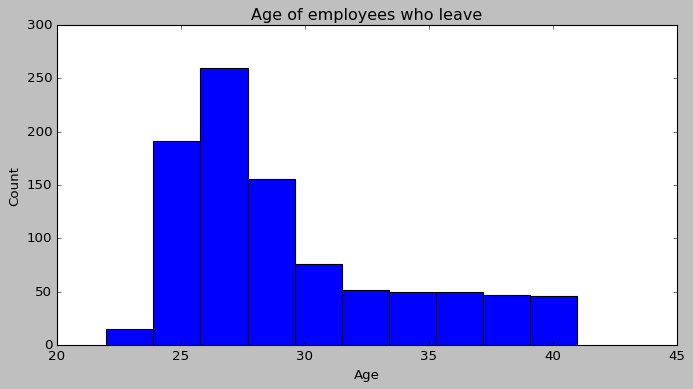

In [93]:
employees_leave_age.plot.hist(bins=10, title='Age of employees who leave',
                               ylabel='Count', xlabel='Age', figsize=(10, 5))

Insight 3: Graphically, in the histogram above, we can observe that young people between the ages of 24 and 30 is more likely to leave the company.

### 2.4. Visualize the balance of the dataset in the column LeaveOrNot

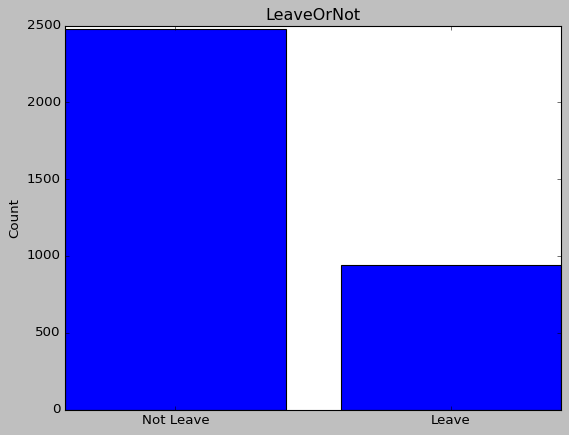

In [99]:
plt.bar(employees_df['LeaveOrNot'].value_counts().index, employees_df['LeaveOrNot'].value_counts())
plt.title('LeaveOrNot')
plt.ylabel('Count')
plt.show()

Graphically we can observe that the dataset is not balanced doe to the number of employees who leave is bigger than the number of employees who do not leave.

## 3. Train a Model to predict leaving the company

### 3.1. Split the dataset into train and test

In [106]:
X = employees_df.drop('LeaveOrNot', axis=1)
y = employees_df['LeaveOrNot']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 3.2. Train two models: Random Forest Classifier the firt one with default parameters and the second one with the argument class_weight='balanced'

In [107]:
rfc = RandomForestClassifier()
rfc2 = RandomForestClassifier(class_weight='balanced')

In [109]:
X_train.dtypes

Education                     object
JoiningYear                  float64
City                          object
PaymentTier                  float64
Age                          float64
Gender                        object
EverBenched                   object
ExperienceInCurrentDomain    float64
dtype: object